In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('apm_cleaned_data1.csv',encoding='utf-8-sig')
df.drop(df.columns[[0]], axis=1, inplace=True) #drop first column
df.head()

,U_ID,age,female,college,church,extrovert,teeth,attention,talkative,sport,...,upbringing,anxiety,newppl,carelike,group,Netflix,urban,politics,convos,y
0,1&32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1
1,1&41,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,1
2,1&33,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,1
3,4&95,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,1
4,4&95,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,1


In [3]:
#define x and y
y = df['y'].values
X = df.iloc[:,1:-1]
X2 = np.array(X)

In [4]:
#train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state=0)

# PU Learning using PosOnly Method 
Refer to https://github.com/aldro61/pu-learning/blob/master/src/puLearning/puAdapter.py

In [5]:
#!/usr/bin/env python
#-*- coding:utf-8 -*-
"""
Created on Dec 21, 2012
@author: Alexandre
"""
import numpy as np

class PUAdapter(object):
    """
    Adapts any probabilistic binary classifier to positive-unlabled learning using the PosOnly method proposed by
    Elkan and Noto:
    Elkan, Charles, and Keith Noto. \"Learning classifiers from only positive and unlabeled data.\"
    Proceeding of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2008.
    """


    def __init__(self, estimator, hold_out_ratio=0.1, precomputed_kernel=False):
        """
        estimator -- An estimator of p(s=1|x) that must implement:
                     * predict_proba(X): Takes X, which can be a list of feature vectors or a precomputed
                                         kernel matrix and outputs p(s=1|x) for each example in X
                     * fit(X,y): Takes X, which can be a list of feature vectors or a precomputed
                                 kernel matrix and takes y, which are the labels associated to the
                                 examples in X
        hold_out_ratio -- The ratio of training examples that must be held out of the training set of examples
                          to estimate p(s=1|y=1) after training the estimator
        precomputed_kernel -- Specifies if the X matrix for predict_proba and fit is a precomputed kernel matrix
        """
        self.estimator = estimator
        self.c = 1.0
        self.hold_out_ratio = hold_out_ratio
        
        if precomputed_kernel:
            self.fit = self.__fit_precomputed_kernel
        else:
            self.fit = self.__fit_no_precomputed_kernel

        self.estimator_fitted = False
        
    def __str__(self):
        return 'Estimator:' + str(self.estimator) + '\n' + 'p(s=1|y=1,x) ~= ' + str(self.c) + '\n' + \
            'Fitted: ' + str(self.estimator_fitted)
    
    
    def __fit_precomputed_kernel(self, X, y):
        """
        Fits an estimator of p(s=1|x) and estimates the value of p(s=1|y=1) using a subset of the training examples
        X -- Precomputed kernel matrix
        y -- Labels associated to each example in X (Positive label: 1.0, Negative label: -1.0)
        """
        positives = np.where(y == 1.)[0]
        hold_out_size = int(np.ceil(len(positives) * self.hold_out_ratio))

        if len(positives) <= hold_out_size:
            raise('Not enough positive examples to estimate p(s=1|y=1,x). Need at least ' + str(hold_out_size + 1) + '.')
        
        np.random.shuffle(positives)
        hold_out = positives[:hold_out_size]
        
        #Hold out test kernel matrix
        X_test_hold_out = X[hold_out]
        keep = list(set(np.arange(len(y))) - set(hold_out))
        X_test_hold_out = X_test_hold_out[:,keep]
        
        #New training kernel matrix
        X = X[:, keep]
        X = X[keep]

        y = np.delete(y, hold_out)
        
        self.estimator.fit(X, y)
        
        hold_out_predictions = self.estimator.predict_proba(X_test_hold_out)
        
        try:
            hold_out_predictions = hold_out_predictions[:,1]
        except:
            pass
        
        c = np.mean(hold_out_predictions)
        self.c = c
        
        self.estimator_fitted = True
        
        
    def __fit_no_precomputed_kernel(self, X, y):
        """
        Fits an estimator of p(s=1|x) and estimates the value of p(s=1|y=1,x)
        X -- List of feature vectors
        y -- Labels associated to each feature vector in X (Positive label: 1.0, Negative label: -1.0)
        """
        positives = np.where(y == 1.)[0] #find where label is positive
        hold_out_size = int(np.ceil(len(positives) * self.hold_out_ratio)) 

        if len(positives) <= hold_out_size:
            raise('Not enough positive examples to estimate p(s=1|y=1,x). Need at least ' + str(hold_out_size + 1) + '.')
        
        np.random.shuffle(positives) #randomly select positives to remove
        hold_out = positives[:hold_out_size] 
        X_hold_out = X[hold_out]
        X = np.delete(X, hold_out,0)
        y = np.delete(y, hold_out)
        
        self.estimator.fit(X, y)
        
        hold_out_predictions = self.estimator.predict_proba(X_hold_out)
        
        try:
            hold_out_predictions = hold_out_predictions[:,1]
        except:
            pass
        
        c = np.mean(hold_out_predictions)
        self.c = c

        self.estimator_fitted = True
        
    
    def predict_proba(self, X):
        """
        Predicts p(y=1|x) using the estimator and the value of p(s=1|y=1) estimated in fit(...)
        X -- List of feature vectors or a precomputed kernel matrix
        """
        if not self.estimator_fitted:
            raise Exception('The estimator must be fitted before calling predict_proba(...).')

        probabilistic_predictions = self.estimator.predict_proba(X)
        
        try:
            probabilistic_predictions = probabilistic_predictions[:,1]
        except:
            pass
        
        return probabilistic_predictions / self.c
    
    
    def predict(self, X, treshold=0.5):
        """
        Assign labels to feature vectors based on the estimator's predictions
        X -- List of feature vectors or a precomputed kernel matrix
        treshold -- The decision treshold between the positive and the negative class
        """
        if not self.estimator_fitted:
            raise Exception('The estimator must be fitted before calling predict(...).')

        return np.array([1. if p > treshold else -1. for p in self.predict_proba(X)])
        
        


# Fitting the PU Adapter to Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1)

In [7]:
# estimator = clf
estimator = clf.fit(X_train,y_train)

In [8]:
obj = PUAdapter(estimator)

In [9]:
obj.fit(X_train, y_train)

In [10]:
#the labels of predicted function in array
y_train_pred = obj.predict(X_train)

In [11]:
#the labels of predicted function in array
y_pred = obj.predict(X_test)

In [12]:
#probabilities of x_test in array
a = obj.predict_proba(X_test)

In [13]:
#find accuracy for test set
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7704598597038191

In [14]:
# find accuracy for train set for comparison
y_train_pred = obj.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.770392749244713

In [15]:
#finding the number of positives within the test set
df1 = pd.DataFrame(a.reshape(-1, len(a)))

#number of labeled positives in test set
poslabel = sum(x == 1 for x in y_test)

#number of positives in test set by predicted probability
pospred = sum(x > .5 for x in a)

#number of pairs in test set
alltest = len(a)


In [16]:
#find baseline occurence of positive class
baseline =  poslabel/alltest
adjusted = (pospred-poslabel)/alltest
lift = adjusted/baseline

print('baseline is', baseline)
print('adjusted is', adjusted)
print('how much more likely',lift)
print('number of additional positives', pospred-107.0)

baseline is 0.00818394388152767
adjusted is 0.22564302416212004
how much more likely 27.571428571428573
number of additional positives 493.0


# Finding most important features

In [17]:
from sklearn.model_selection import GridSearchCV

# Specify L1 regularization
lr = LogisticRegression(penalty='l1')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.001}
Total number of features: 24
Number of selected features: 5


In [18]:
print (coefs!=0)
print (coefs)

[[ True False False False  True False False False False False False False
  False  True False False False False False False  True False  True False]]
[[-0.37925416  0.          0.          0.         -0.01367957  0.
   0.          0.          0.          0.          0.          0.
   0.         -0.34757521  0.          0.          0.          0.
   0.          0.         -0.00206069  0.         -0.40198492  0.        ]]


In [ ]:
# These features are: age, extrovert, charity, Netflix, political affiliation 

# ROC Curve

Text(0.5,1,'ROC Curve for LogReg, AUC = .837')

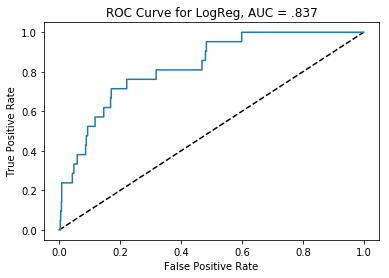

In [19]:
# Import necessary modules
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities: y_pred_prob
# y_pred_prob = logreg.predict_proba(X_test)[:,1]
a = obj.predict_proba(X_test)
B = np.reshape(a, (-1, 2))
y_pred_prob = B[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, a)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='%s ROC (area = .837)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogReg, AUC = .837')


# # Compute and print AUC score
# print("AUC: {}".format(roc_auc_score(y_test, a)))

# # Calculate Area under the curve to display on the plot
# auc = metrics.roc_auc_score(y_test,a)
# # Now, plot the computed values
# plt.plot(fpr, tpr, label='%s ROC (area = .837)')

In [20]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = B[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, a)))

AUC: 0.827476845355038


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


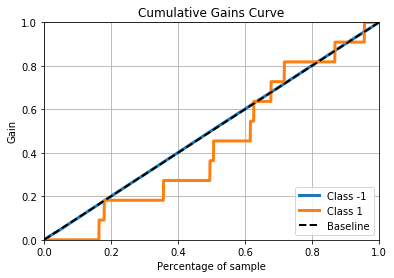

In [21]:
# The magic happens here
# cumuative gain plot for PU adapter logistic regression
predicted_probas = a

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, B)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


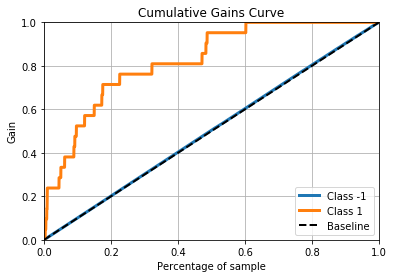

In [22]:
# cumuative gain plot for plain logistic regression
predicted_probas = estimator.predict_proba(X_test)

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()